In [2]:
#Hilfscode zum finden meines Arbeitsverzeichnis und der vorhanden Dateien
import os
print("Aktuelles Arbeitsverzeichnis:", os.getcwd())

input_dir = '/kaggle/input/'

for root, dirs, files in os.walk(input_dir):
    print(f"Verzeichnis: {root}")
    print(f"Unterordner: {dirs}")
    print(f"Dateien: {files}")
    print('---')

Aktuelles Arbeitsverzeichnis: /kaggle/working
Verzeichnis: /kaggle/input/
Unterordner: ['datasets-naivebayes']
Dateien: []
---
Verzeichnis: /kaggle/input/datasets-naivebayes
Unterordner: []
Dateien: ['dataset_base.xlsx', 'dataset.xlsx', 'dataset_roberta_sentences.xlsx', 'dataset_roberta_chunks.xlsx', 'dataset_finbert_sentences.xlsx', 'dataset_finbert_chunks.xlsx']
---


In [3]:
#Dataset laden
import pandas as pd
import numpy as np

print("Lade Datensätze...")

# Alle Datasets laden
df_data = pd.read_excel('/kaggle/input/datasets-naivebayes/dataset.xlsx')
df_base = pd.read_excel('/kaggle/input/datasets-naivebayes/dataset_base.xlsx')
df_fin_sen = pd.read_excel('/kaggle/input/datasets-naivebayes/dataset_finbert_sentences.xlsx')
df_fin_chk = pd.read_excel('/kaggle/input/datasets-naivebayes/dataset_finbert_chunks.xlsx')
df_rob_sen = pd.read_excel('/kaggle/input/datasets-naivebayes/dataset_roberta_sentences.xlsx')
df_rob_chk = pd.read_excel('/kaggle/input/datasets-naivebayes/dataset_roberta_chunks.xlsx')

# Date-Index setzen und One-Hot-Encoded columns konvertieren für alle DataFrames
for df in [df_data, df_base, df_fin_sen, df_fin_chk, df_rob_sen, df_rob_chk]:
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
    df.set_index('Date', inplace=True)
    onehot_cols = ['Index_MDAX', 'Index_SDAX']
    df[onehot_cols] = df[onehot_cols].astype(np.float64)

print("✓ Alle Datensätze erfolgreich geladen!")
print(f"df_data: {df_data.shape}")
print(f"df_base: {df_base.shape}")
print(f"df_fin_sen: {df_fin_sen.shape}")
print(f"df_fin_chk: {df_fin_chk.shape}")
print(f"df_rob_sen: {df_rob_sen.shape}")
print(f"df_rob_chk: {df_rob_chk.shape}")


Lade Datensätze...
✓ Alle Datensätze erfolgreich geladen!
df_data: (69, 14)
df_base: (69, 10)
df_fin_sen: (69, 11)
df_fin_chk: (69, 11)
df_rob_sen: (69, 11)
df_rob_chk: (69, 11)


In [4]:
#Train/Testsets creation
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

# Konfiguration für Train/Test-Split
config = {
    'use_fixed_testset': False,
    'test_size': 15,
    'random_state': 33,
    'fixed_test_dates': [
        '2024-01-25',
        '2023-05-04',
        '2023-02-02',
        '2025-03-06',
        '2024-10-17'
    ]
}

# Train/Test Split Logik (basierend auf df_base)
if config['use_fixed_testset']:
    test_dates = pd.to_datetime(config['fixed_test_dates'])
    test_indices = df_base.index.isin(test_dates)
    train_indices = ~test_indices
else:
    np.random.seed(config['random_state'])
    unique_dates = df_base.index.normalize().unique()
    n_dates = config['test_size'] // 3
    
    dates_zero = []
    dates_positive = []
    dates_negative = []
    
    for date in unique_dates:
        values = df_base.loc[df_base.index.normalize() == date, 'Interest Rate_Change']
        if (values == 0.00).any():
            dates_zero.append(date)
        if (values > 0.00).any():
            dates_positive.append(date)
        if (values < 0.00).any():
            dates_negative.append(date)
    
    selected_dates = []
    selected_dates.append(np.random.choice(dates_zero))
    selected_dates.append(np.random.choice(dates_positive))
    selected_dates.append(np.random.choice(dates_negative))
    
    remaining = [d for d in unique_dates if d not in selected_dates]
    if n_dates > 3:
        additional = np.random.choice(remaining, size=n_dates-3, replace=False)
        selected_dates.extend(additional)
    
    test_indices = df_base.index.normalize().isin(selected_dates)
    train_indices = ~test_indices

# Alle DataFrames aufteilen
train_set = df_base.loc[train_indices]
test_set = df_base.loc[test_indices]

train_fin_sen = df_fin_sen.loc[train_indices]
test_fin_sen = df_fin_sen.loc[test_indices]

train_fin_chk = df_fin_chk.loc[train_indices]
test_fin_chk = df_fin_chk.loc[test_indices]

train_rob_sen = df_rob_sen.loc[train_indices]
test_rob_sen = df_rob_sen.loc[test_indices]

train_rob_chk = df_rob_chk.loc[train_indices]
test_rob_chk = df_rob_chk.loc[test_indices]

# Ausgabe der Shapes
datasets = [
    ('base', train_set, test_set),
    ('fin_sen', train_fin_sen, test_fin_sen),
    ('fin_chk', train_fin_chk, test_fin_chk),
    ('rob_sen', train_rob_sen, test_rob_sen),
    ('rob_chk', train_rob_chk, test_rob_chk)
]

for name, train, test in datasets:
    print(f"{name} - Train-Set Shape: {train.shape}")
    print(f"{name} - Test-Set  Shape: {test.shape}")


base - Train-Set Shape: (54, 10)
base - Test-Set  Shape: (15, 10)
fin_sen - Train-Set Shape: (54, 11)
fin_sen - Test-Set  Shape: (15, 11)
fin_chk - Train-Set Shape: (54, 11)
fin_chk - Test-Set  Shape: (15, 11)
rob_sen - Train-Set Shape: (54, 11)
rob_sen - Test-Set  Shape: (15, 11)
rob_chk - Train-Set Shape: (54, 11)
rob_chk - Test-Set  Shape: (15, 11)


# Linear Regression

In [4]:
#Short Summary Finbert and BASE
import numpy as np
import pandas as pd
from joblib import dump
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Define target columns
target_columns = ['Close', 'Close_t+1', 'Close_t+2']

# Define 2 different datasets (train/test pairs) - only base and fin_sen
datasets = {
    'base': {'train': train_set, 'test': test_set},
    'fin_sen': {'train': train_fin_sen, 'test': test_fin_sen}
}

# Define target-specific Bayesian Ridge parameters
target_params = {
    'Close': {
        'n_iter': 1,
        'tol': 1e-07,
        'alpha_1': 1e-06,
        'alpha_2': 1e-05,
        'lambda_1': 1e-05,
        'lambda_2': 1e-06,
        'alpha_init': 0.1,
        'lambda_init': None,
        'fit_intercept': False
    },
    'Close_t+1': {
        'n_iter': 1,
        'tol': 1e-07,
        'alpha_1': 1e-05,
        'alpha_2': 1e-06,
        'lambda_1': 1e-06,
        'lambda_2': 1e-05,
        'alpha_init': 1.0,
        'lambda_init': 0.01,
        'fit_intercept': False
    },
    'Close_t+2': {
        'n_iter': 1,
        'tol': 1e-07,
        'alpha_1': 1e-06,
        'alpha_2': 1e-05,
        'lambda_1': 1e-05,
        'lambda_2': 1e-06,
        'alpha_init': 0.01,
        'lambda_init': None,
        'fit_intercept': False
    }
}

# Initialize results list
results = []

# Main loop: Iterate through datasets
for dataset_name, data in datasets.items():
    
    train_data = data['train']
    test_data = data['test']
    
    # Get feature columns (exclude target columns)
    feature_columns = [col for col in train_data.columns if col not in target_columns]
    
    # Prepare data arrays for current dataset
    X_train = train_data[feature_columns].values
    X_test = test_data[feature_columns].values
    
    # Create separate scaler for each dataset
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Create target dictionaries for current dataset
    y_train_dict = {t: train_data[t].values for t in target_columns}
    y_test_dict = {t: test_data[t].values for t in target_columns}
    
    # Calculate baseline statistics for current dataset
    baseline_stats = {}
    for t in target_columns:
        y_tr, y_te = y_train_dict[t], y_test_dict[t]
        y_mean = np.mean(y_tr)
        
        baseline_stats[t] = {
            'train_mse': mean_squared_error(y_tr, np.full_like(y_tr, y_mean)),
            'test_mse': mean_squared_error(y_te, np.full_like(y_te, y_mean)),
            'train_r2': r2_score(y_tr, np.full_like(y_tr, y_mean)),
            'test_r2': r2_score(y_te, np.full_like(y_te, y_mean))
        }
    
    # Loop through targets
    for target in target_columns:
        
        y_tr, y_te = y_train_dict[target], y_test_dict[target]
        bl = baseline_stats[target]
        
        # Get target-specific parameters
        bayesian_params = target_params[target]
        
        # Create Bayesian Ridge model with target-specific parameters
        model = BayesianRidge(**bayesian_params)
        
        # Fit model using scaled features
        model.fit(X_train_scaled, y_tr)
        
        # Calculate train/test predictions and metrics
        train_pred = model.predict(X_train_scaled)
        test_pred = model.predict(X_test_scaled)
        
        train_mse = mean_squared_error(y_tr, train_pred)
        test_mse = mean_squared_error(y_te, test_pred)
        train_r2 = r2_score(y_tr, train_pred)
        test_r2 = r2_score(y_te, test_pred)
        
        # Format metrics with baseline
        train_mse_str = f"{train_mse:.4f} ({bl['train_mse']:.4f})"
        test_mse_str = f"{test_mse:.4f} ({bl['test_mse']:.4f})"
        train_r2_str = f"{train_r2:.4f} ({bl['train_r2']:.4f})"
        test_r2_str = f"{test_r2:.4f} ({bl['test_r2']:.4f})"
        
        # Store results WITHOUT CV_MSE
        results.append({
            'Target': target,
            'Model': dataset_name,
            'Train_MSE': train_mse_str,
            'Test_MSE': test_mse_str,
            'Train_R²': train_r2_str,
            'Test_R²': test_r2_str,
            'Best_Params': bayesian_params
        })
        
        # Save the model
        dump(model, f"best_model_mse_{dataset_name}_{target}_cv9.joblib")

# Create DataFrame WITHOUT CV_MSE
df_results = pd.DataFrame(results)

# Funktion zum Extrahieren des numerischen Train_MSE-Werts aus dem formatierten String
def extract_train_mse(value):
    return float(value.split(' (')[0])

# Sortieren nach Target und dann nach kleinstem Train_MSE innerhalb jeder Target-Kategorie
df_results['Train_MSE_num'] = df_results['Train_MSE'].apply(extract_train_mse)
df_results_sorted = df_results.sort_values(by=['Target', 'Train_MSE_num']).reset_index(drop=True)

# Ausgabe vorbereiten mit Leerzeilen zwischen Target-Kategorien
output_lines = []
current_target = None
for idx, row in df_results_sorted.iterrows():
    if current_target != row['Target']:
        if current_target is not None:
            output_lines.append('')  # Leerzeile vor neuer Target-Kategorie
        current_target = row['Target']
    line = f"{row['Target']:<10} {row['Model']:<10} {row['Train_MSE']:<20} {row['Test_MSE']:<20} {row['Train_R²']:<15} {row['Test_R²']:<15}"
    output_lines.append(line)

# Header und Trenner
header = f"{'Target':<10} {'Model':<10} {'Train_MSE':<20} {'Test_MSE':<20} {'Train_R²':<15} {'Test_R²':<15}"
separator = '-' * len(header)

# Display results with sorted output and blank lines between targets
print("\n" + "="*80)
print("RESULTS SUMMARY:")
print("="*80)

# Endausgabe
final_output = '\n'.join([header, separator] + output_lines)
print(final_output)



RESULTS SUMMARY:
Target     Model      Train_MSE            Test_MSE             Train_R²        Test_R²        
-----------------------------------------------------------------------------------------------
Close      fin_sen    1.1718 (1.5769)      1.4287 (0.9743)      0.2569 (0.0000) -0.7165 (-0.1706)
Close      base       1.2547 (1.5769)      1.3485 (0.9743)      0.2043 (0.0000) -0.6201 (-0.1706)

Close_t+1  fin_sen    1.5805 (2.4972)      4.2436 (1.3888)      0.3671 (0.0000) -2.3792 (-0.1059)
Close_t+1  base       1.6147 (2.4972)      4.0952 (1.3888)      0.3534 (0.0000) -2.2611 (-0.1059)

Close_t+2  fin_sen    2.6343 (2.7915)      1.9588 (2.1635)      0.0563 (0.0000) -0.1738 (-0.2964)
Close_t+2  base       2.6461 (2.7915)      1.9742 (2.1635)      0.0521 (0.0000) -0.1830 (-0.2964)


In [24]:
import numpy as np
import pandas as pd
from joblib import dump
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import StandardScaler

# 0. How many top features to show
top_n = 10

# 1. Define target columns and datasets
target_columns = ['Close', 'Close_t+1', 'Close_t+2']
datasets = {
    'base':    train_set,
    'fin_sen': train_fin_sen
}

# 2. Target-specific Bayesian Ridge parameters
target_params = {
    'Close': {
        'n_iter': 1,
        'tol': 1e-07,
        'alpha_1': 1e-06,
        'alpha_2': 1e-05,
        'lambda_1': 1e-05,
        'lambda_2': 1e-06,
        'alpha_init': 0.1,
        'lambda_init': None,
        'fit_intercept': False
    },
    'Close_t+1': {
        'n_iter': 1,
        'tol': 1e-07,
        'alpha_1': 1e-05,
        'alpha_2': 1e-06,
        'lambda_1': 1e-06,
        'lambda_2': 1e-05,
        'alpha_init': 1.0,
        'lambda_init': 0.01,
        'fit_intercept': False
    },
    'Close_t+2': {
        'n_iter': 1,
        'tol': 1e-07,
        'alpha_1': 1e-06,
        'alpha_2': 1e-05,
        'lambda_1': 1e-05,
        'lambda_2': 1e-06,
        'alpha_init': 0.01,
        'lambda_init': None,
        'fit_intercept': False
    }
}

def top_n_linear_df(df, feature_cols, target, n=5):
    """Fit scaled BayesianRidge for one target and return top-n coefficients."""
    X = df[feature_cols].values
    y = df[target].values
    scaler = StandardScaler().fit(X)
    Xs = scaler.transform(X)
    model = BayesianRidge(**target_params[target]).fit(Xs, y)

    coefs = pd.Series(model.coef_, index=feature_cols)
    top_idx = coefs.abs().nlargest(n).index
    return pd.DataFrame({'Weight': coefs.loc[top_idx]})

def print_side_by_side(dfs, padding=10):
    """Print multiple DataFrames side by side in console with spacing."""
    lines_list = [df.to_string().splitlines() for df in dfs]
    widths = [max(len(line) for line in lines) for lines in lines_list]
    max_rows = max(len(lines) for lines in lines_list)
    # pad shorter tables
    for lines, w in zip(lines_list, widths):
        lines += [' ' * w] * (max_rows - len(lines))
    # print combined rows
    for row in zip(*lines_list):
        print(''.join(row[i].ljust(widths[i] + padding) for i in range(len(row))))

# Main loop: compute and print for each dataset
for ds_name, df in datasets.items():
    feature_columns = [c for c in df.columns if c not in target_columns]
    dfs, titles = [], []

    # 1) Print English heading before tables
    heading = f"========== Feature Importances for Dataset '{ds_name}' (Top {top_n}, sorted by absolute weight) =========="
    print(f"\n\n\n{heading}\n")

    # 2) Build top-n tables and simplified titles
    for target in target_columns:
        df_top = top_n_linear_df(df, feature_columns, target, n=top_n)
        dfs.append(df_top)
        titles.append(f"'{ds_name}' Top {top_n} for '{target}'")

    # 3) Print titles header
    header = ''.join(
        titles[i].ljust(len(dfs[i].to_string().splitlines()[0]) + 10)
        for i in range(len(dfs))
    )
    print(f"\n{header}\n")

    # 4) Print the tables side by side
    print_side_by_side(dfs, padding=10)

    # 5) Optionally save each fitted model
    for target in target_columns:
        X = df[feature_columns].values
        y = df[target].values
        scaler = StandardScaler().fit(X)
        Xs = scaler.transform(X)
        model = BayesianRidge(**target_params[target]).fit(Xs, y)
        dump(model, f"bayesian_ridge_{ds_name}_{target}.joblib")





========== Feature Importances for Dataset 'base' (Top 10, sorted by absolute weight) ==========


'base' Top 10 for 'Close'               'base' Top 10 for 'Close_t+1'           'base' Top 10 for 'Close_t+2'           

                        Weight                                  Weight                                  Weight          
Close_t-4             0.303909          Close_t-3             0.994684          Close_t-3             0.114233          
Interest Rate_Change -0.302767          Close_t-2            -0.727552          Interest Rate_Change -0.112420          
Close_t-3             0.230876          Interest Rate_Old    -0.611778          Interest Rate_Old    -0.099995          
Index_SDAX            0.117365          Interest Rate_Change -0.610008          Close_t-4             0.086967          
Interest Rate_Old    -0.097548          Close_t-4             0.264031          Index_SDAX            0.032776          
Close_t-2            -0.088848          Index_SDAX

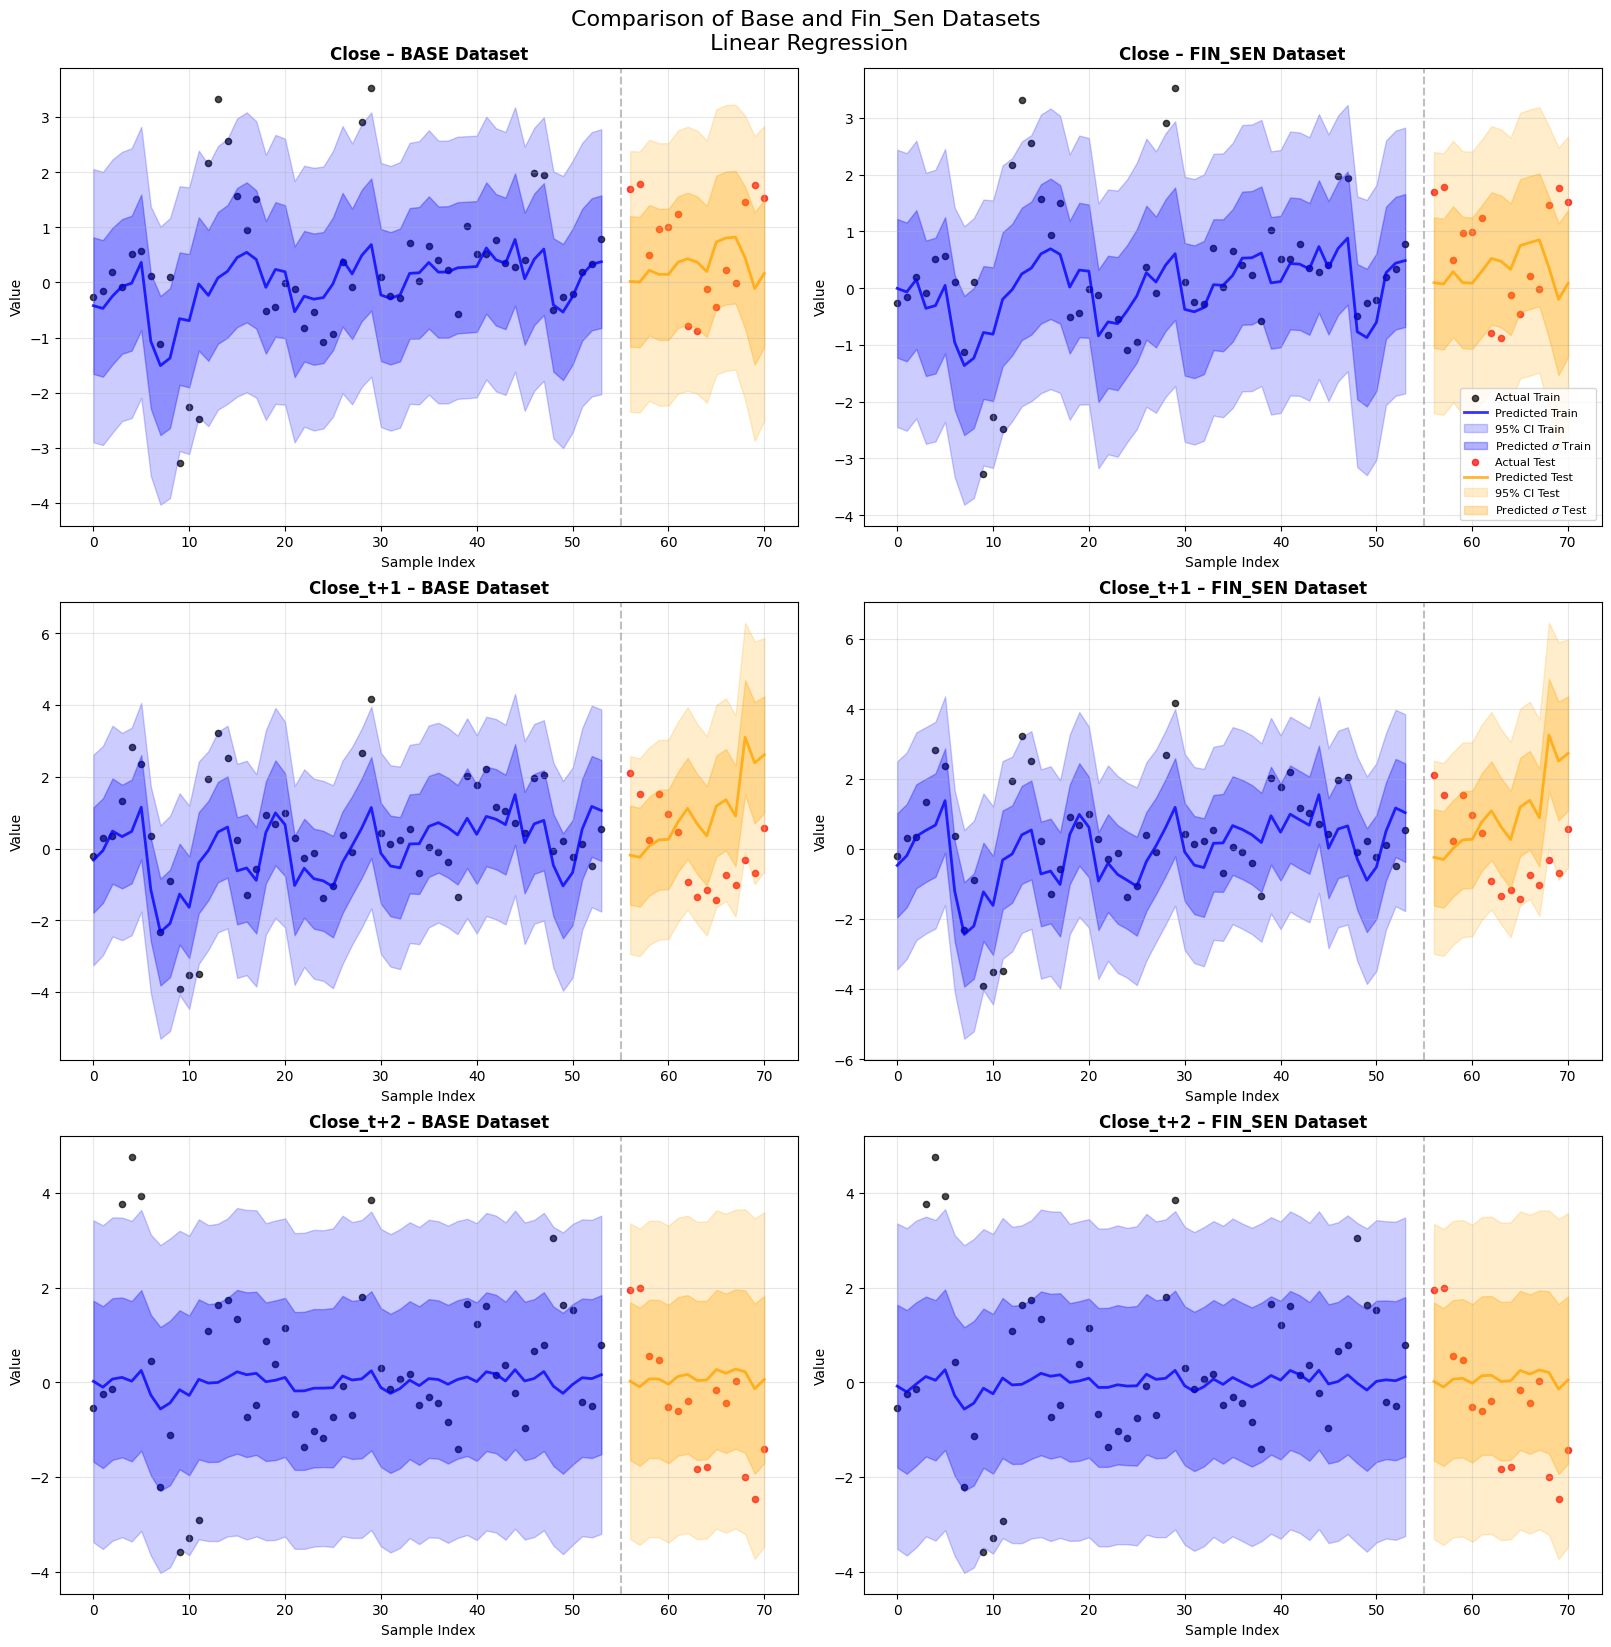

📁 Download files:


/kaggle/working/bayesian_ridge_comparison_linear_white.png

/kaggle/working/bayesian_ridge_comparison_linear_transparent.png

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import os

# Create directory if it doesn't exist
os.makedirs('/kaggle/working', exist_ok=True)

# Define target columns
target_columns = ['Close', 'Close_t+1', 'Close_t+2']

# Define 2 different datasets (train/test pairs) - only base and fin_sen
datasets = {
    'base': {'train': train_set, 'test': test_set},
    'fin_sen': {'train': train_fin_sen, 'test': test_fin_sen}
}

# Define target-specific Bayesian Ridge parameters
target_params = {
    'Close': {
        'n_iter': 1,
        'tol': 1e-07,
        'alpha_1': 1e-06,
        'alpha_2': 1e-05,
        'lambda_1': 1e-05,
        'lambda_2': 1e-06,
        'alpha_init': 0.1,
        'lambda_init': None,
        'fit_intercept': False
    },
    'Close_t+1': {
        'n_iter': 1,
        'tol': 1e-07,
        'alpha_1': 1e-05,
        'alpha_2': 1e-06,
        'lambda_1': 1e-06,
        'lambda_2': 1e-05,
        'alpha_init': 1.0,
        'lambda_init': 0.01,
        'fit_intercept': False
    },
    'Close_t+2': {
        'n_iter': 1,
        'tol': 1e-07,
        'alpha_1': 1e-06,
        'alpha_2': 1e-05,
        'lambda_1': 1e-05,
        'lambda_2': 1e-06,
        'alpha_init': 0.01,
        'lambda_init': None,
        'fit_intercept': False
    }
}

# Plotting setup: 3 rows (targets) x 2 columns (datasets)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 16), constrained_layout=True)

for i, target in enumerate(target_columns):
    for j, dataset_name in enumerate(datasets.keys()):
        data = datasets[dataset_name]
        train_data = data['train']
        test_data = data['test']
        
        # Get feature columns (exclude target columns)
        feature_columns = [c for c in train_data.columns if c not in target_columns]
        
        # Prepare and scale features
        X_train = train_data[feature_columns].values
        X_test = test_data[feature_columns].values
        scaler = StandardScaler().fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Prepare targets
        y_train = train_data[target].values
        y_test = test_data[target].values
        
        # Get target-specific parameters
        params = target_params[target]
        
        # Create and train Bayesian Ridge model with target-specific parameters
        model = BayesianRidge(**params)
        model.fit(X_train_scaled, y_train)
        
        # Make predictions with uncertainty
        pred_train, train_std = model.predict(X_train_scaled, return_std=True)
        pred_test, test_std = model.predict(X_test_scaled, return_std=True)
        
        # Calculate metrics
        metrics = {
            'train_r2': r2_score(y_train, pred_train),
            'test_r2': r2_score(y_test, pred_test),
            'train_mse': mean_squared_error(y_train, pred_train),
            'test_mse': mean_squared_error(y_test, pred_test)
        }
        
        # Plot
        ax = axes[i, j]
        N_train = len(y_train)
        N_test = len(y_test)
        
        # Plot training data
        ax.scatter(np.arange(N_train), y_train, label='Actual Train', s=20, color='black', alpha=0.7)
        ax.plot(np.arange(N_train), pred_train, 
               label='Predicted Train', 
               color='blue', linewidth=2, alpha=0.8)
        ax.fill_between(np.arange(N_train), pred_train - 2*train_std, pred_train + 2*train_std, 
                       alpha=0.2, color='blue', label='95% CI Train')
        ax.fill_between(np.arange(N_train), pred_train - train_std, pred_train + train_std, 
                       alpha=0.3, color='blue', label=r'Predicted $\sigma$ Train')
        
        # Add test data overlay
        test_offset = N_train + 2  # Small gap between train and test
        ax.scatter(np.arange(test_offset, test_offset + N_test), y_test, 
                  label='Actual Test', s=20, color='red', alpha=0.7)
        ax.plot(np.arange(test_offset, test_offset + N_test), pred_test, 
               label='Predicted Test', 
               color='orange', linewidth=2, alpha=0.8)
        ax.fill_between(np.arange(test_offset, test_offset + N_test), 
                       pred_test - 2*test_std, pred_test + 2*test_std, 
                       alpha=0.2, color='orange', label='95% CI Test')
        ax.fill_between(np.arange(test_offset, test_offset + N_test), 
                       pred_test - test_std, pred_test + test_std, 
                       alpha=0.3, color='orange', label=r'Predicted $\sigma$ Test')
        
        # Add vertical line to separate train/test
        ax.axvline(x=N_train + 1, color='gray', linestyle='--', alpha=0.5)
        
        ax.set_title(f'{target} – {dataset_name.upper()} Dataset', fontsize=12, fontweight='bold')
        ax.set_xlabel('Sample Index')
        ax.set_ylabel('Value')
        ax.grid(alpha=0.3)
        
        # Add legend only to the first row, right column (top-right plot)
        if i == 0 and j == 1:
            ax.legend(fontsize=8, loc='lower right')

plt.suptitle('Comparison of Base and Fin_Sen Datasets\n Linear Regression', 
             fontsize=16, y=1.02)

# Save with white background
plt.savefig('/kaggle/working/bayesian_ridge_comparison_linear_white.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')

# Save with transparent background
plt.savefig('/kaggle/working/bayesian_ridge_comparison_linear_transparent.png', dpi=300, bbox_inches='tight', 
            transparent=True, edgecolor='none')

plt.show()

# Provide download links for Kaggle
from IPython.display import FileLink, display
print("📁 Download files:")
display(FileLink('/kaggle/working/bayesian_ridge_comparison_linear_white.png'))
display(FileLink('/kaggle/working/bayesian_ridge_comparison_linear_transparent.png'))


# Polynomial Regression

In [29]:
#Short Summary Finbert and BASE
import numpy as np
import pandas as pd
from joblib import dump
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

# Define target columns
target_columns = ['Close', 'Close_t+1', 'Close_t+2']

# Define 2 datasets: base and fin_sen
datasets = {
    'base':    {'train': train_set,     'test': test_set},
    'fin_sen': {'train': train_fin_sen, 'test': test_fin_sen}
}

# Fixed Bayesian Ridge parameters
bayesian_params = {
    'n_iter':      1,
    'tol':         1e-07,
    'alpha_1':     1e-06,
    'alpha_2':     1e-05,
    'lambda_1':    1e-05,
    'lambda_2':    1e-06,
    'alpha_init':  0.01,
    'lambda_init': None,
    'fit_intercept': False
}

results = []

for dataset_name, data in datasets.items():
    train_data = data['train']
    test_data  = data['test']
    
    feature_columns = [c for c in train_data.columns if c not in target_columns]
    X_train = train_data[feature_columns].values
    X_test  = test_data [feature_columns].values
    
    # 1) Scale raw features
    scaler    = StandardScaler().fit(X_train)
    X_train_s = scaler.transform(X_train)
    X_test_s  = scaler.transform(X_test)
    
    # 2) Create polynomial transformer (2nd degree)
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_train_p = poly.fit_transform(X_train_s)
    X_test_p  = poly.transform(X_test_s)
    
    # Prepare targets
    y_train = {t: train_data[t].values for t in target_columns}
    y_test  = {t: test_data [t].values for t in target_columns}
    
    # Baseline stats
    baseline_stats = {}
    for t in target_columns:
        y_tr, y_te = y_train[t], y_test[t]
        mu = np.mean(y_tr)
        baseline_stats[t] = {
            'train_mse': mean_squared_error(y_tr, np.full_like(y_tr, mu)),
            'test_mse':  mean_squared_error(y_te, np.full_like(y_te, mu)),
            'train_r2':  r2_score(y_tr, np.full_like(y_tr, mu)),
            'test_r2':   r2_score(y_te, np.full_like(y_te, mu))
        }
    
    # Fit & evaluate each target
    for t in target_columns:
        y_tr, y_te = y_train[t], y_test[t]
        bl = baseline_stats[t]
        
        # 3) Bayesian Ridge on polynomial features
        model = BayesianRidge(**bayesian_params)
        model.fit(X_train_p, y_tr)
        
        train_pred = model.predict(X_train_p)
        test_pred  = model.predict(X_test_p)
        
        tmse = mean_squared_error(y_tr, train_pred)
        tmse_str = f"{tmse:.4f} ({bl['train_mse']:.4f})"
        tmsq2 = mean_squared_error(y_te, test_pred)
        tmsq2_str= f"{tmsq2:.4f} ({bl['test_mse']:.4f})"
        tr2 = r2_score(y_tr, train_pred)
        tr2_str= f"{tr2:.4f} ({bl['train_r2']:.4f})"
        te2 = r2_score(y_te, test_pred)
        te2_str= f"{te2:.4f} ({bl['test_r2']:.4f})"
        
        results.append({
            'Target':   t,
            'Model':    dataset_name,
            'Train_MSE': tmse_str,
            'Test_MSE':  tmsq2_str,
            'Train_R²':  tr2_str,
            'Test_R²':   te2_str
        })
        
        dump(model, f"poly2_bayesian_{dataset_name}_{t}.joblib")

# Build and display results
df_results = pd.DataFrame(results)
df_results['Train_MSE_val'] = df_results['Train_MSE'].map(lambda s: float(s.split(' ')[0]))
df_results = df_results.sort_values(['Target','Train_MSE_val']).reset_index(drop=True)

header = f"{'Target':<10}{'Model':<12}{'Train_MSE':<20}{'Test_MSE':<20}{'Train_R²':<20}{'Test_R²':<15}"
sep = '-'*len(header)
print(header); print(sep)
current=None
for _,row in df_results.iterrows():
    if row['Target']!=current:
        if current: print()
        current=row['Target']
    print(f"{row['Target']:<10}{row['Model']:<12}{row['Train_MSE']:<20}{row['Test_MSE']:<20}{row['Train_R²']:<20}{row['Test_R²']:<15}")


Target    Model       Train_MSE           Test_MSE            Train_R²            Test_R²        
-------------------------------------------------------------------------------------------------
Close     fin_sen     1.1922 (1.5769)     0.9859 (0.9743)     0.2440 (0.0000)     -0.1844 (-0.1706)
Close     base        1.3233 (1.5769)     0.8915 (0.9743)     0.1608 (0.0000)     -0.0710 (-0.1706)

Close_t+1 fin_sen     1.7768 (2.4972)     2.2908 (1.3888)     0.2885 (0.0000)     -0.8242 (-0.1059)
Close_t+1 base        1.8628 (2.4972)     2.1623 (1.3888)     0.2540 (0.0000)     -0.7219 (-0.1059)

Close_t+2 fin_sen     1.6182 (2.7915)     1.4320 (2.1635)     0.4203 (0.0000)     0.1419 (-0.2964)
Close_t+2 base        1.8955 (2.7915)     1.3716 (2.1635)     0.3210 (0.0000)     0.1781 (-0.2964)


In [25]:
import numpy as np
import pandas as pd
from joblib import dump
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

# 0. How many top features to show
top_n = 10  # <-- Set this to any number of top features you want

# 1. Define target and feature columns
target_columns = ['Close', 'Close_t+1', 'Close_t+2']

# 2. Fixed Bayesian Ridge parameters
bayesian_params = {
    'n_iter':        1,
    'tol':           1e-07,
    'alpha_1':       1e-06,
    'alpha_2':       1e-05,
    'lambda_1':      1e-05,
    'lambda_2':      1e-06,
    'alpha_init':    0.01,
    'lambda_init':   None,
    'fit_intercept': False
}

def top_n_coef_df(df, feature_cols, target, n=5):
    """Fit pipeline for one target and return top-n coefficients as DataFrame."""
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('bayes', BayesianRidge(**bayesian_params))
    ])
    X = df[feature_cols].values
    y = df[target].values
    pipe.fit(X, y)
    
    names = pipe.named_steps['poly'].get_feature_names_out(feature_cols)
    coefs = pipe.named_steps['bayes'].coef_
    coef_series = pd.Series(coefs, index=names)
    
    top_feats = coef_series.abs().nlargest(n).index
    top_weights = coef_series.loc[top_feats]
    
    return pd.DataFrame({'Weight': top_weights})

def print_side_by_side(dfs, padding=10):
    """Print multiple DataFrames side by side in console."""
    line_lists = [df.to_string().splitlines() for df in dfs]
    widths = [max(len(line) for line in lines) for lines in line_lists]
    max_lines = max(len(lines) for lines in line_lists)
    
    # pad shorter tables
    for lines, w in zip(line_lists, widths):
        lines += [' ' * w] * (max_lines - len(lines))
    
    for row in zip(*line_lists):
        print(''.join(row[i].ljust(widths[i] + padding) for i in range(len(row))))

# Main loop: compute and print for each dataset
for ds_name, df in [('base', train_set), ('finbert', train_fin_sen)]:
    feature_columns = [c for c in df.columns if c not in target_columns]
    
    # 1) Print English heading before tables
    heading = f"========== Feature Importances for Dataset '{ds_name}' (Top {top_n}, sorted by absolute weight) =========="
    print("\n\n\n" + heading + "\n")
    
    # 2) Build top-n tables and simplified titles
    dfs, titles = [], []
    for target in target_columns:
        df_top = top_n_coef_df(df, feature_columns, target, n=top_n)
        dfs.append(df_top)
        titles.append(f"'{ds_name}' Top {top_n} for '{target}'")
    
    # 3) Print all titles in one header row
    header = ''.join(
        titles[i].ljust(len(dfs[i].to_string().splitlines()[0]) + 10)
        for i in range(len(dfs))
    )
    print("\n" + header + "\n")
    
    # 4) Print the three tables side by side
    print_side_by_side(dfs, padding=10)
    
    # 5) Optionally save each fitted pipeline
    for target in target_columns:
        model = Pipeline([
            ('scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=2, include_bias=False)),
            ('bayes', BayesianRidge(**bayesian_params))
        ]).fit(df[feature_columns].values, df[target].values)
        dump(model, f"poly2_bayes_{ds_name}_{target}.joblib")





========== Feature Importances for Dataset 'base' (Top 10, sorted by absolute weight) ==========


'base' Top 10 for 'Close'                         'base' Top 10 for 'Close_t+1'                     'base' Top 10 for 'Close_t+2'                     

                                  Weight                                            Weight                                            Weight          
Interest Rate_Change           -0.089457          Close_t-3                       0.157368          Close_t-4 Interest Rate_Old    -0.177086          
Close_t-4                       0.087872          Interest Rate_Change           -0.136825          Close_t-4 Interest Rate_Change  0.157274          
Close_t-3                       0.087262          Close_t-4                       0.129582          Close_t-2 Interest Rate_Change -0.142113          
Index_SDAX^2                    0.054570          Close_t-2 Interest Rate_Change -0.118426          Close_t-4^2                     0.140141  

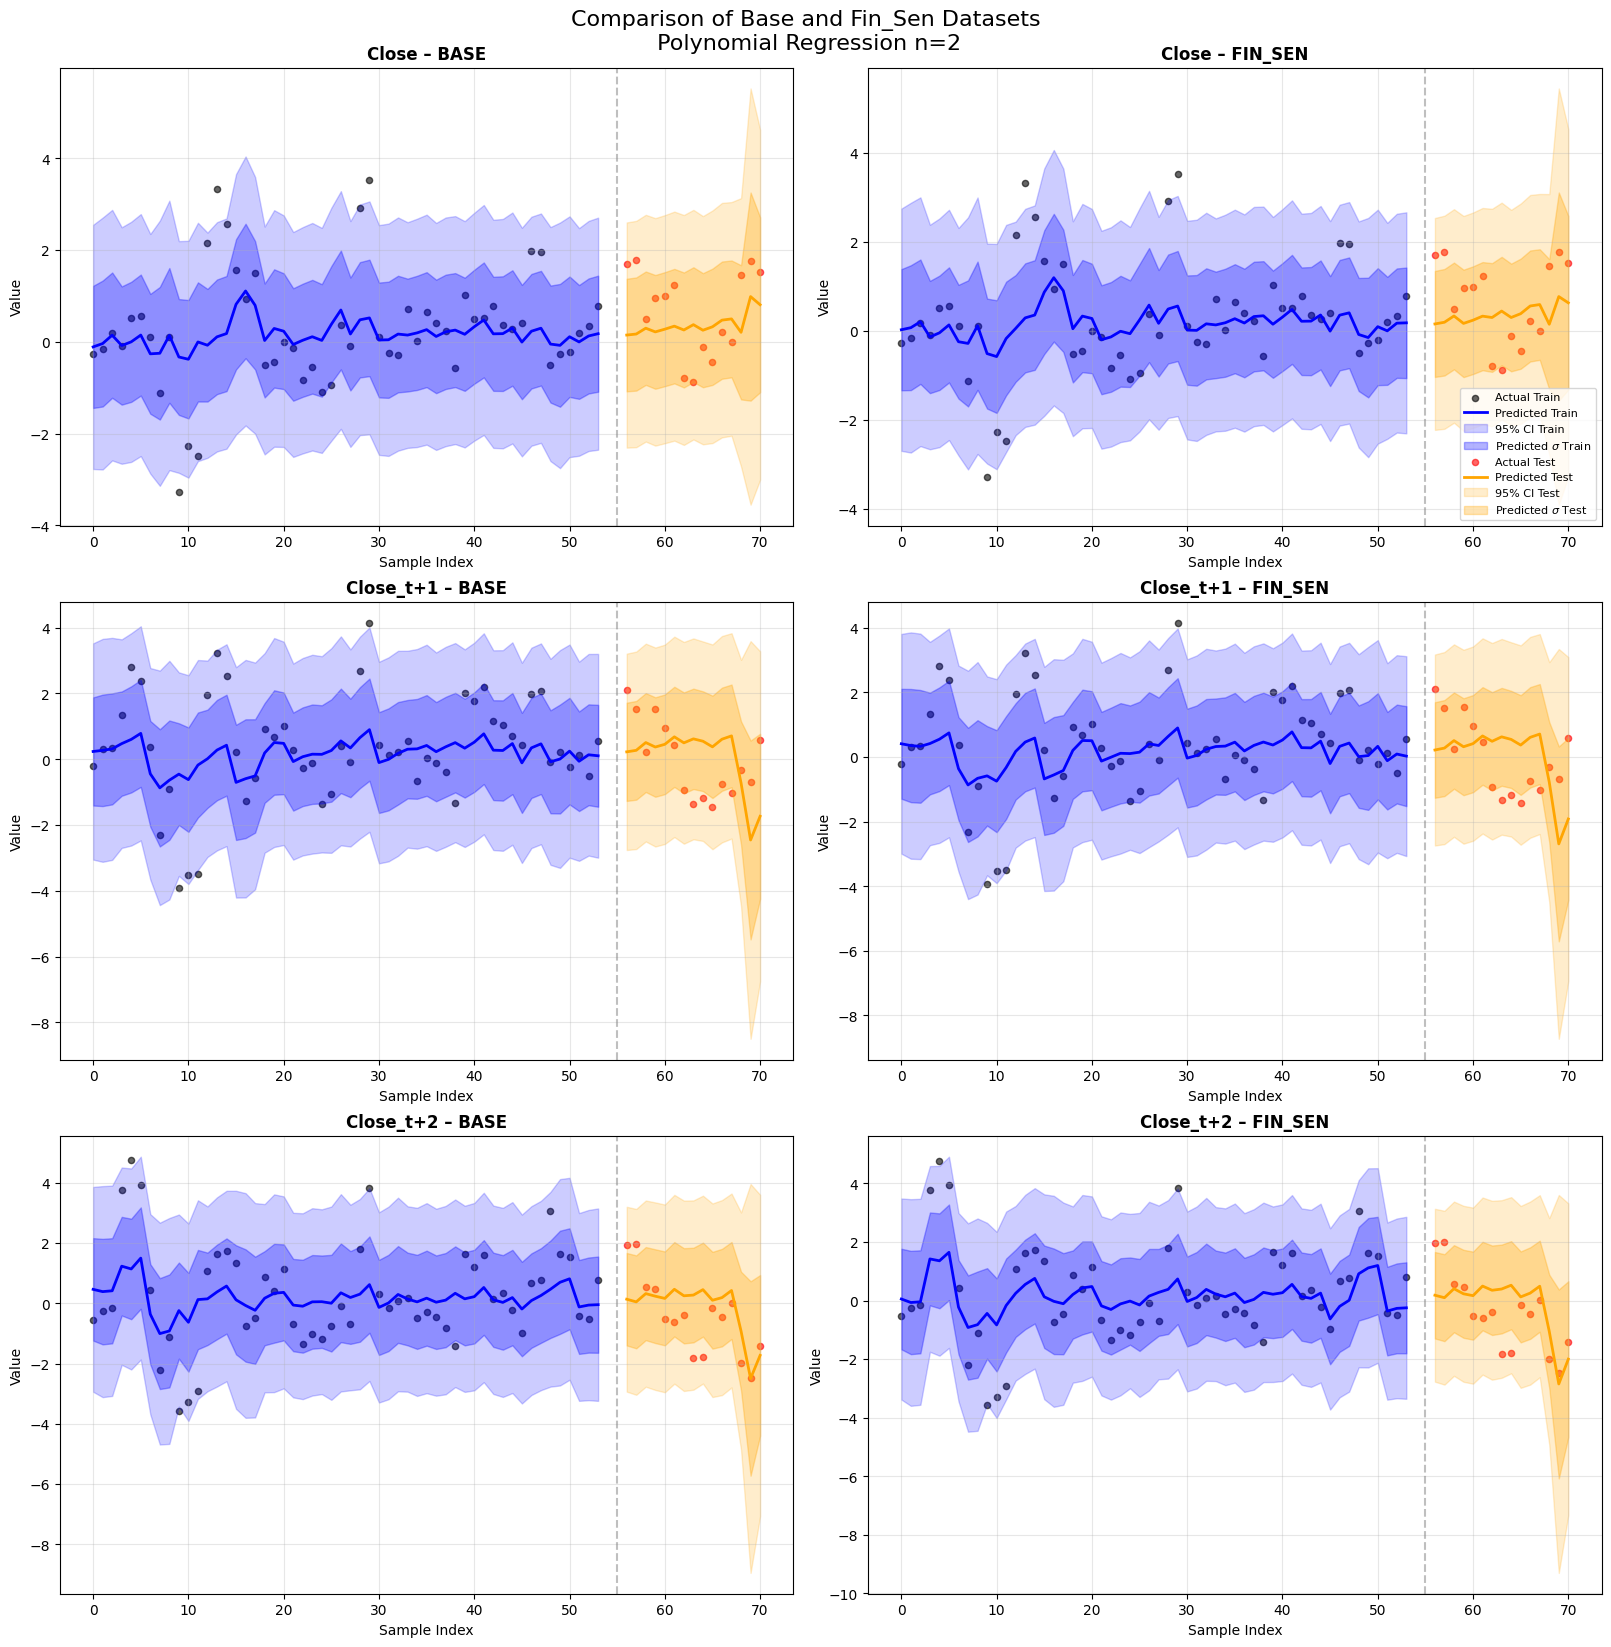

📁 Download files:


/kaggle/working/polynomial_bayesian_ridge_comparison_white.png

/kaggle/working/polynomial_bayesian_ridge_comparison_transparent.png

In [6]:
#Visualizing
import numpy as np
import matplotlib.pyplot as plt
from joblib import dump
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
import os

# Create directory if it doesn't exist
os.makedirs('/kaggle/working', exist_ok=True)

# 1. Konfiguration
TARGETS = ['Close','Close_t+1','Close_t+2']
DATASETS = {
    'base':    (train_set, test_set),
    'fin_sen': (train_fin_sen, test_fin_sen)
}
PARAMS = {
    'n_iter': 1, 'tol': 1e-7,#1e-7
    'alpha_1': 1e-6, 'alpha_2': 1e-5, #1e-5,
    'lambda_1': 1e-5, 'lambda_2': 1e-6,
    'alpha_init': 0.01, 'lambda_init': None,
    'fit_intercept': False
}

fig, axes = plt.subplots(len(TARGETS), 2, figsize=(16,16), constrained_layout=True)

for i, t in enumerate(TARGETS):
    for j, (name, (df_tr, df_te)) in enumerate(DATASETS.items()):
        # Features & Targets
        X_tr = df_tr.drop(columns=TARGETS).values
        y_tr = df_tr[t].values
        X_te = df_te.drop(columns=TARGETS).values
        y_te = df_te[t].values

        # 2) Fit scaler + polynomial on TRAIN of this dataset
        scaler = StandardScaler().fit(X_tr)
        X_tr_s = scaler.transform(X_tr)
        X_te_s = scaler.transform(X_te)

        poly = PolynomialFeatures(degree=2, include_bias=False).fit(X_tr_s)
        X_tr_p = poly.transform(X_tr_s)
        X_te_p = poly.transform(X_te_s)

        # 3) Train Bayesian Ridge auf polyn. Features
        model = BayesianRidge(**PARAMS)
        model.fit(X_tr_p, y_tr)

        # 4) Vorhersagen + Metriken
        pred_tr, std_tr = model.predict(X_tr_p, return_std=True)
        pred_te, std_te = model.predict(X_te_p, return_std=True)

        m_tr = mean_squared_error(y_tr, pred_tr)
        r2_tr = r2_score(y_tr, pred_tr)
        m_te = mean_squared_error(y_te, pred_te)
        r2_te = r2_score(y_te, pred_te)

        # 5) Plotten
        ax = axes[i, j]
        N1, N2 = len(y_tr), len(y_te)

        ax.scatter(np.arange(N1), y_tr, color='black', s=20, alpha=0.6, label='Actual Train')
        ax.plot(   np.arange(N1), pred_tr, color='blue', lw=2,
                   label='Predicted Train')
        ax.fill_between(np.arange(N1), pred_tr-2*std_tr, pred_tr+2*std_tr, color='blue', alpha=0.2, label='95% CI Train')
        ax.fill_between(np.arange(N1), pred_tr-std_tr, pred_tr+std_tr, color='blue', alpha=0.3, label=r'Predicted $\sigma$ Train')

        offset = N1 + 2
        ax.scatter(np.arange(offset, offset+N2), y_te, color='red', s=20, alpha=0.6, label='Actual Test')
        ax.plot(   np.arange(offset, offset+N2), pred_te, color='orange', lw=2,
                   label='Predicted Test')
        ax.fill_between(np.arange(offset, offset+N2), pred_te-2*std_te, pred_te+2*std_te, color='orange', alpha=0.2, label='95% CI Test')
        ax.fill_between(np.arange(offset, offset+N2), pred_te-std_te, pred_te+std_te, color='orange', alpha=0.3, label=r'Predicted $\sigma$ Test')

        ax.axvline(x=offset-1, color='gray', linestyle='--', alpha=0.5)
        ax.set_title(f'{t} – {name.upper()}', fontweight='bold')
        ax.set_xlabel('Sample Index')
        ax.set_ylabel('Value')
        
        # Add legend only to the first row, right column (top-right plot)
        if i == 0 and j == 1:
            ax.legend(fontsize=8, loc='lower right')
        
        ax.grid(alpha=0.3)

        # Modell speichern
        dump(model, f"poly2_bayes_{name}_{t}.joblib")

plt.suptitle("Comparison of Base and Fin_Sen Datasets\n Polynomial Regression n=2", fontsize=16, y=1.02)

# Save with white background
plt.savefig('/kaggle/working/polynomial_bayesian_ridge_comparison_polynomial_white.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')

# Save with transparent background
plt.savefig('/kaggle/working/polynomial_bayesian_ridge_comparison_polynomial_transparent.png', dpi=300, bbox_inches='tight', 
            transparent=True, edgecolor='none')

plt.show()

